# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [1]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

--2024-11-17 23:41:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [               <=>  ]  58.17M  3.01MB/s    in 41s     

2024-11-17 23:42:40 (1.41 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Archive:  UCI HAR Dataset.zip
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: UCI HAR Dataset/test/X_test.txt  
  inflating: UCI HAR Dataset/test/y_test.txt  
  inflating: UCI HAR Dataset/train/X_train.txt  
  inflating: UCI HAR Dataset/train/y_train.txt  


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [3]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [4]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [5]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [6]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

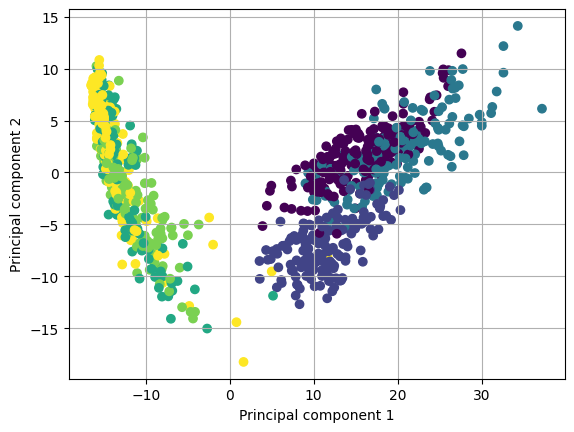

In [9]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

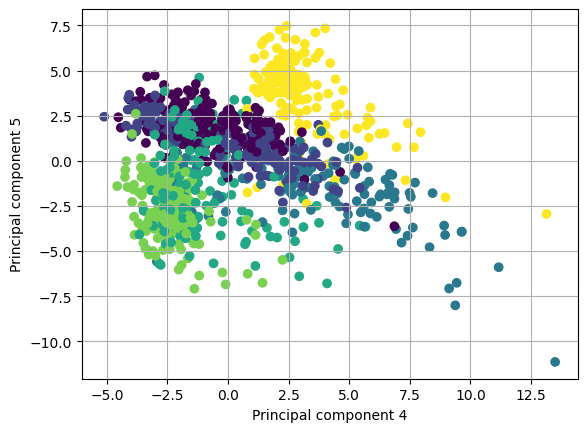

In [16]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [ ]:
from catboost import CatBoostClassifier
from itertools import product
from sklearn.model_selection import train_test_split

X_tr,X_val,y_tr,y_val= train_test_split(X_train,y_train,test_size=0.8)


for depth,learning_rate,l2_leaf_reg in product([4,6,8],[1e-2,1e-1,1],[0.1,1,10]):
    print(
        f'{depth=},{learning_rate=},{l2_leaf_reg=}',
        CatBoostClassifier(iterations=50,depth=depth, learning_rate=learning_rate,l2_leaf_reg=l2_leaf_reg,eval_metric='Accuracy').fit(
            X_tr, 
            y_tr, 
            eval_set=(X_val, y_val), 
            early_stopping_rounds=50,
            verbose=False
        ).best_score_['validation']['Accuracy'],
    )

depth=4,learning_rate=0.01,l2_leaf_reg=0.1 0.9200952057123427
depth=4,learning_rate=0.01,l2_leaf_reg=1 0.9197551853111187
depth=4,learning_rate=0.01,l2_leaf_reg=10 0.9177150629037742
depth=4,learning_rate=0.1,l2_leaf_reg=0.1 0.9496769806188371
depth=4,learning_rate=0.1,l2_leaf_reg=1 0.9476368582114927
depth=4,learning_rate=0.1,l2_leaf_reg=10 0.9384563073784427
depth=4,learning_rate=1,l2_leaf_reg=0.1 0.9270656239374363
depth=4,learning_rate=1,l2_leaf_reg=1 0.9348860931655899
depth=4,learning_rate=1,l2_leaf_reg=10 0.9360761645698742
depth=6,learning_rate=0.01,l2_leaf_reg=0.1 0.9297857871472288
depth=6,learning_rate=0.01,l2_leaf_reg=1 0.9263855831349881
depth=6,learning_rate=0.01,l2_leaf_reg=10 0.9199251955117307
depth=6,learning_rate=0.1,l2_leaf_reg=0.1 0.9603876232573955
depth=6,learning_rate=0.1,l2_leaf_reg=1 0.9546072764365862
depth=6,learning_rate=0.1,l2_leaf_reg=10 0.9435566133968039


## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [ ]:
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
import optuna
from catboost import CatBoostClassifier
from optuna.integration import CatBoostPruningCallback

X_tr,X_val,y_tr,y_val= train_test_split(X_train_unique,y_train,test_size=0.8)


def suggestion(trial: optuna.trial.BaseTrial):
    return {
        'iterations': 50,
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e-1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
    }

def objective(trial: optuna.trial.BaseTrial):
    return CatBoostClassifier(**suggestion(trial=trial,),eval_metric='Accuracy',).fit(
        X_tr, 
        y_tr, 
        eval_set=(X_val, y_val), 
        callbacks=[CatBoostPruningCallback(trial, 'Accuracy')],
        verbose=False
    ).best_score_['validation']['Accuracy']

# Run the optimization process

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Get the best parameters
best_params = study.best_params
print(f'Best Parameters: {best_params}, Accuracy: {study.best_value}')

/home/bug/GirafeMLAutumn2024/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-18 01:12:12,113] A new study created in memory with name: no-name-126707f1-bd81-4e09-b128-82e929cbfadd
/tmp/ipykernel_19863/2174145903.py:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks=[CatBoostPruningCallback(trial, 'Accuracy')],
[I 2024-11-18 01:12:29,320] Trial 0 finished with value: 0.91652499149949 and parameters: {'depth': 6, 'learning_rate': 0.03055848927940886, 'l2_leaf_reg': 7.113024173928401}. Best is trial 0 with value: 0.91652499149949.
[I 2024-11-18 01:12:34,352] Trial 1 finished with value: 0.9102346140768446 and parameters: {'depth': 4, 'learning_rate': 0.015944159181609355, 'l2_leaf_reg': 0.71113582954

### Conclusion

Please, write down your thoughts on the experiment results:

I have limited budget by setting number of iterations to 50, selected almost the same grid and number of steps of hyperparameter optimization
for justified comparison of results between optuna and plain search.

Before start of experiment it was evident that due to shape of dataset, we have significant overtraining risk. Note, that we have around 10 object per feature. So high l2-coefficient is beneficial for achieving high results on validation. Also small number of iterations, probably will enjoy deeper trees.

Unfortunately, optuna just halts on my pc : ( 


## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [7]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split


X_tr,X_val,y_tr,y_val= train_test_split(X_train_unique,y_train,test_size=0.8)
model = CatBoostClassifier(iterations=50,depth=6,learning_rate=0.1,l2_leaf_reg=0.1).fit(X_tr,y_tr,verbose=False)

/home/bug/GirafeMLAutumn2024/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


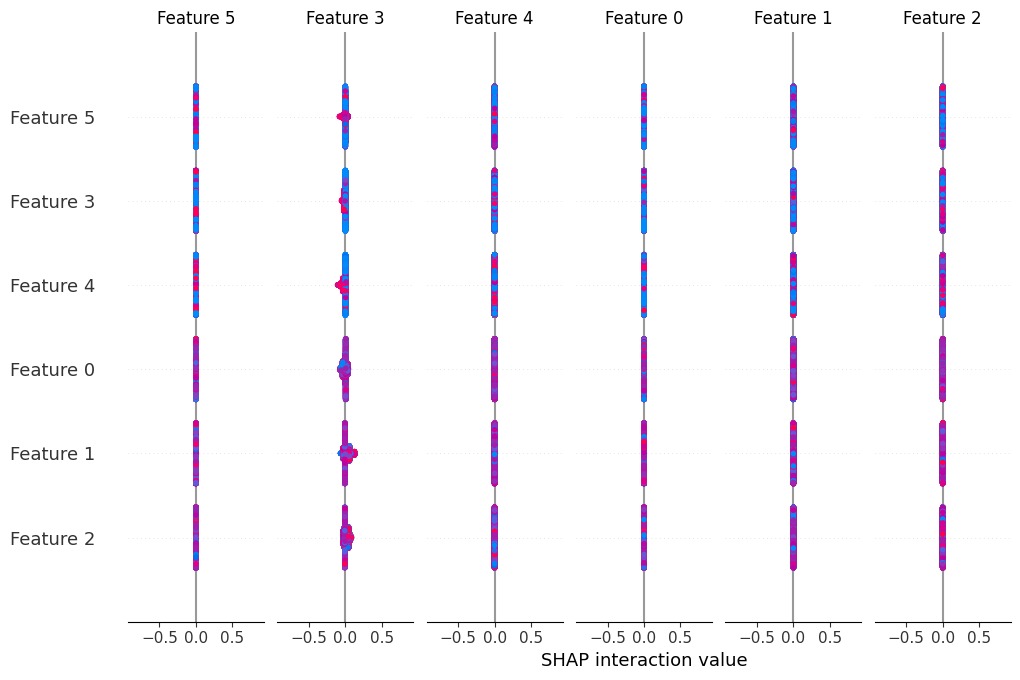

In [8]:
import shap  # noqa: F401
from catboost import Pool

explainer = shap.TreeExplainer(model)

# Calculate Shapley values
shap_values = explainer.shap_values(Pool(X_val))

# Visualize global feature importance
shap.summary_plot(shap_values, X_val)

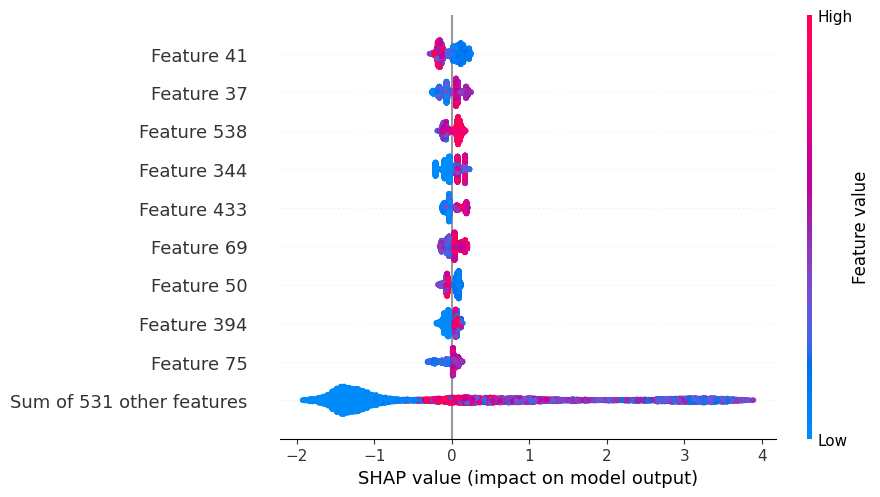

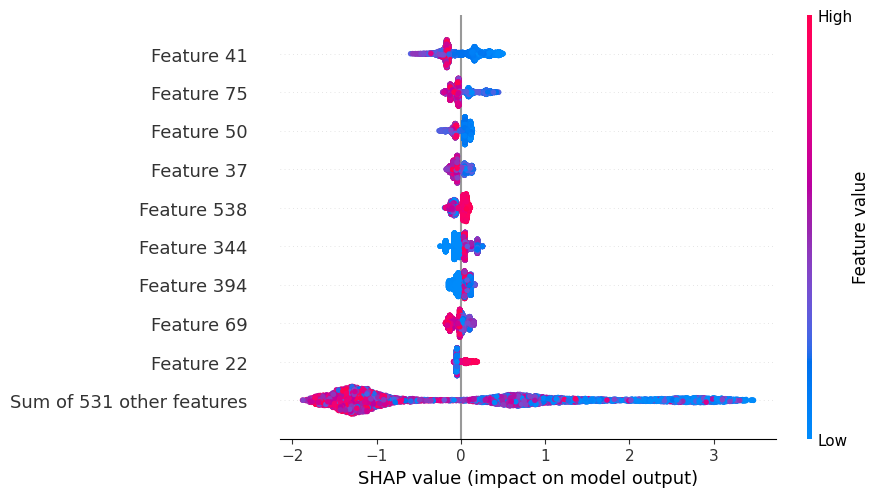

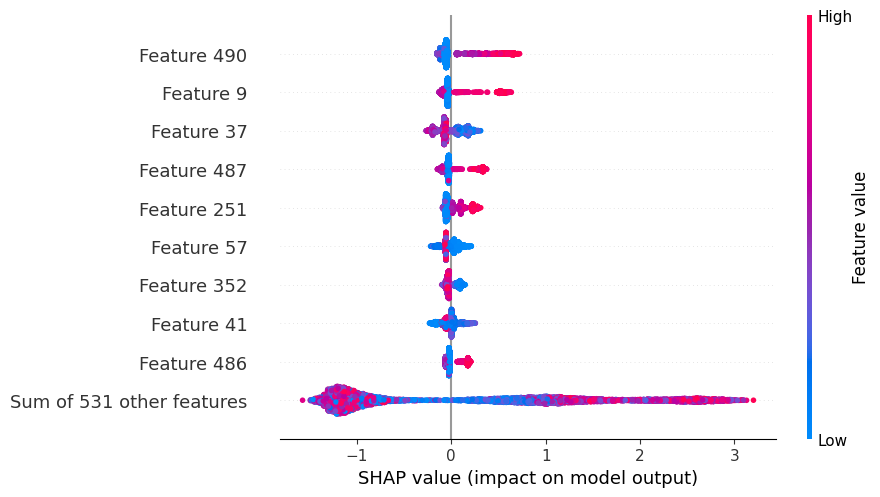

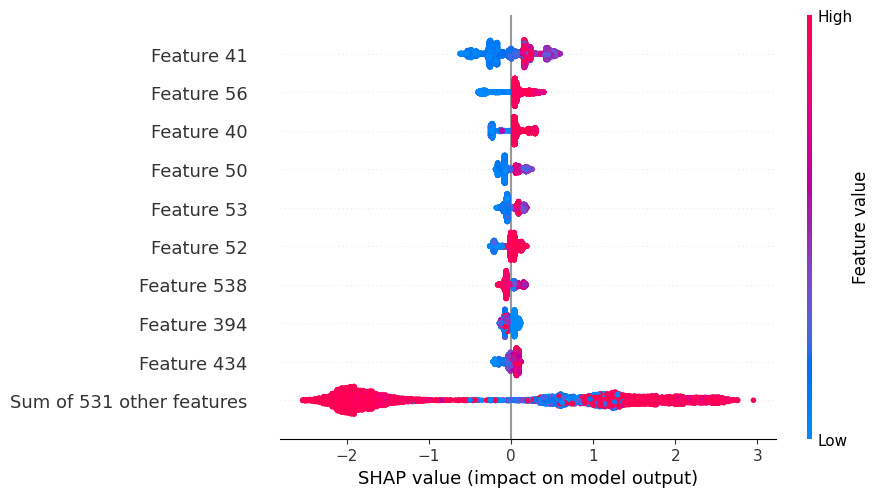

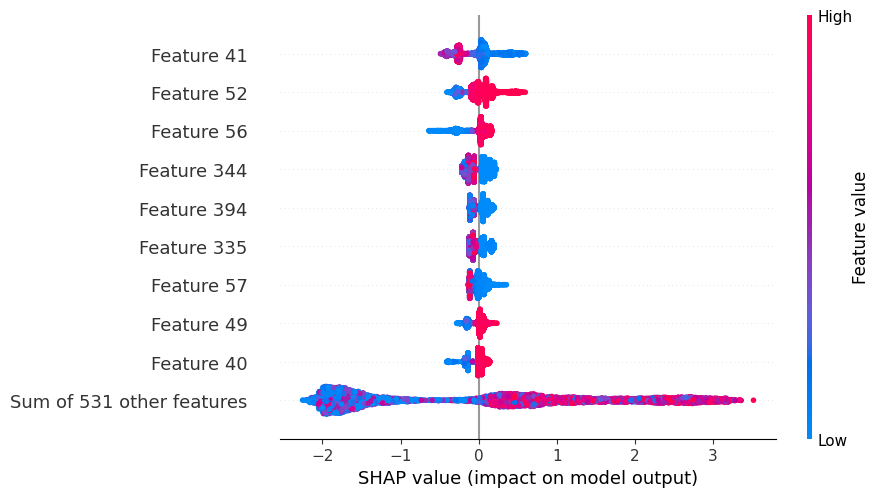

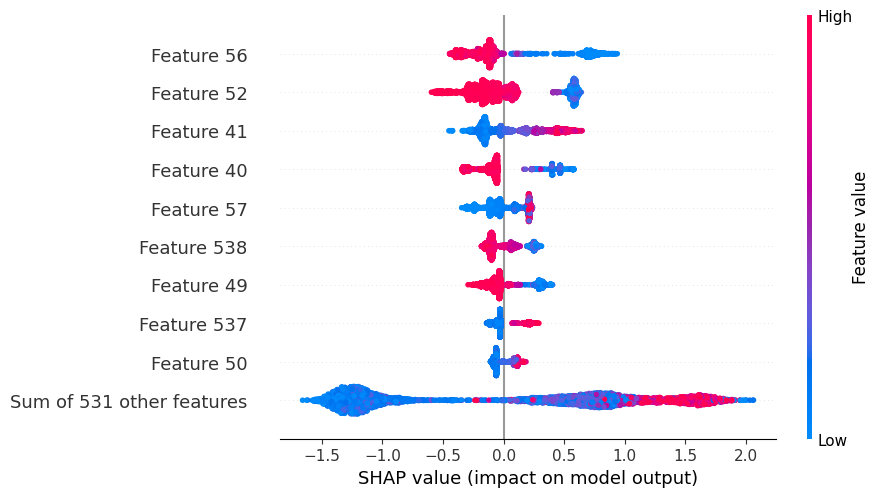

In [13]:
import matplotlib.pyplot as plt
shap_values = explainer(X_val, y_val)
for i in range(6):
    shap.plots.beeswarm(shap_values[..., i])
    plt.show()

### Conclusion

Your thoughts about the plots and model behaviour:

Beesworm is probably most helpful for understanding model inference in whole. We see that every class it's own set of dominant feature, which are mostly monotonic in their shap value. Hence, dataset might enjoy easier models like logistic regression on pca features. Albeit most explanation value is restricted to others features, which might not justify selection of easier model. Let's see

In [61]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression('l1',C=10,solver='saga').fit(X_train_pca,y_train)

/home/bug/GirafeMLAutumn2024/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [62]:
np.mean(model.predict(X_test_pca) == y_test)

0.9409569053274517

That is, result are pretty same. Let's see weights distribution

<Axes: ylabel='Count'>

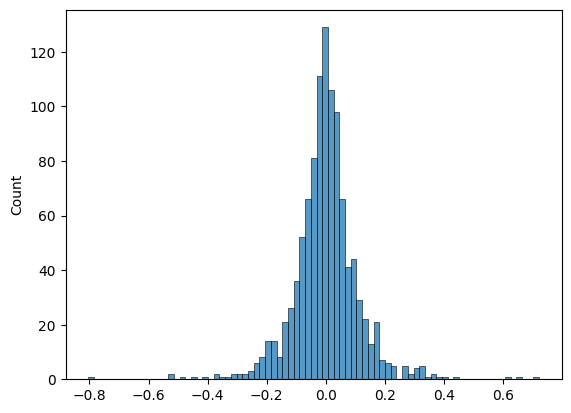

In [63]:
import seaborn as sns
sns.histplot(model.coef_.reshape(-1))

Seems pretty normal. Let's cut 95% of weights and clarify results. So let's prune weights behind sigma

In [64]:
import copy
right_coef = copy.deepcopy(model.coef_)

In [65]:
import scipy.stats as sps
results = []
thresholds = np.linspace(0.1,0.99,20)
for threshold in thresholds:
    model.coef_ = np.where(np.abs(right_coef) > sps.norm.ppf(0.5+0.5*threshold) * right_coef.reshape(-1).std(), right_coef,0)
    results.append(np.mean(model.predict(X_test_pca) == y_test))

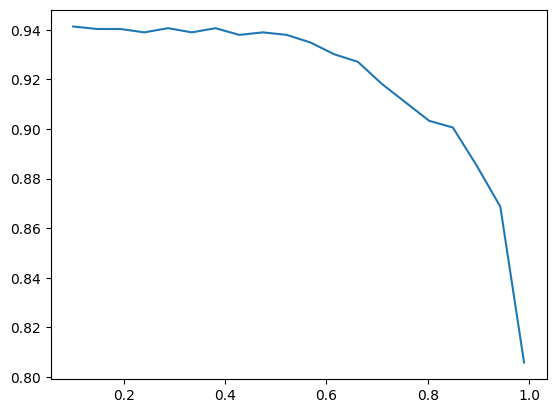

In [66]:
plt.plot(thresholds,results)

Pretty good results are still achieved with 60% of weights pruned : ) 